In [1]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [2]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FPT Historical Data 10 years.csv')
df = pd.read_csv('../Datasets/INTC Historical Data.csv')
df1=df.reset_index()['Price']
df.size

11368

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_val, yval = create_dataset(val_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)

In [7]:
#6. New

time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size-100]
X_test = X[train_size-100:train_size-100+test_size]
X_val = X[train_size-100+test_size:]

y_train = y[:train_size-100]
ytest = y[train_size-100:train_size-100+test_size]
yval = y[train_size+test_size-100:]

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 31s 298ms/step - loss: 0.1808 - val_loss: 0.0735
Epoch 2/100
14/14 [==============================] - 1s 99ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 3/100
14/14 [==============================] - 1s 97ms/step - loss: 0.0106 - val_loss: 0.0200
Epoch 4/100
14/14 [==============================] - 1s 107ms/step - loss: 0.0094 - val_loss: 0.0201
Epoch 5/100
14/14 [==============================] - 1s 107ms/step - loss: 0.0087 - val_loss: 0.0170
Epoch 6/100
14/14 [==============================] - 1s 102ms/step - loss: 0.0079 - val_loss: 0.0162
Epoch 7/100
14/14 [==============================] - 1s 103ms/step - loss: 0.0076 - val_loss: 0.0143
Epoch 8/100
14/14 [==============================] - 1s 105ms/step - loss: 0.0071 - val_loss: 0.0127
Epoch 9/100
14/14 [==============================] - 1s 105ms/step - loss: 0.0064 - val_loss: 0.0103
Epoch 10/100
14/14 [==============================] - 1s 107ms/step - loss: 0.0059 - val_los

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 8ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

In [14]:
# 13. Dự báo 30 ngày tiếp theo

# n_steps=100
# x_input=val_data[60:].reshape(1,-1)

n_steps=time_step
x_input=val_data[-n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<30):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.22749962]
101
1 day input [0.11016755 0.11911866 0.07482213 0.0700023  0.07711728 0.09570806
 0.12141382 0.12439752 0.08698646 0.09524902 0.07665825 0.06495295
 0.06655956 0.08377324 0.08583888 0.09065871 0.07574019 0.06219876
 0.02662382 0.0130824  0.01629562 0.00550838 0.         0.00068855
 0.00986918 0.02983704 0.03442736 0.02501721 0.01445949 0.0247877
 0.03534542 0.05324765 0.04705072 0.07137939 0.08056002 0.1211843
 0.11269222 0.0977737  0.0817076  0.07413358 0.09478999 0.10236401
 0.09823273 0.1007574  0.15193941 0.1650218  0.17833372 0.18338306
 0.18820289 0.18200597 0.18154694 0.17489098 0.17098921 0.16341519
 0.16593987 0.16043149 0.16616938 0.1590544  0.14344733 0.13679137
 0.12393849 0.10924948 0.09134726 0.09524902 0.1138398  0.14138168
 0.12393849 0.11177416 0.13197154 0.14551297 0.13977507 0.13472573
 0.11934818 0.11636447 0.09088823 0.09295387 0.1124627  0.09915079
 0.09111774 0.10970852 0.11544641 0.12347946 0.10580675 0.09410145
 0.05737893 0.09410145 0.1168235  0

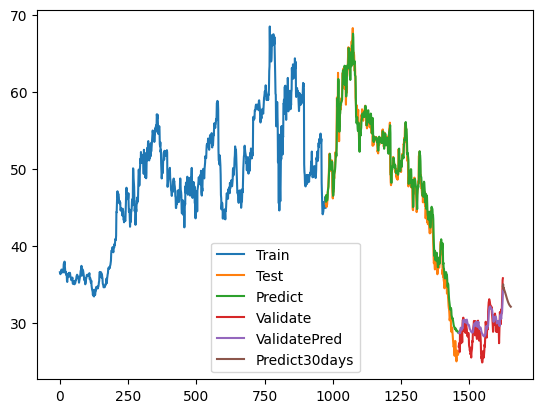

In [15]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [16]:
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mse = mean_squared_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)
test_mape = mape(ytest, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
valid_mse = mean_squared_error(yval, y_pred_val)
valid_mae = mean_absolute_error(yval, y_pred_val)
valid_mape = mape(yval, y_pred_val)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
print("Validation MAPE:", valid_mape)

Testing RMSE: 49.91223692089144
Testing MAE: 49.124223346058685
Testing MAPE: 20868.43010769612
Validation RMSE: 29.865917151058866
Validation MAE: 29.847654052597495
Validation MAPE: inf


C:\Users\dangnghiepcuong\AppData\Local\Temp\ipykernel_7016\899879837.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((actual - predicted) / actual)) * 100


In [17]:
print(scaler.inverse_transform(lst_output)[:10, 0])

[34.81215841 35.03419647 34.45527569 34.58192689 34.29608701 34.33237129
 34.19157957 34.12951902 33.9895843  33.89747611]


In [18]:
print(df['Price'].tail(10))

1614    31.31
1615    29.86
1616    30.96
1617    31.28
1618    31.82
1619    31.34
1620    33.07
1621    33.91
1622    35.58
1623    35.82
Name: Price, dtype: float64


In [19]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# pred_ind = list(range(len(df1), len(df1)+30))
# x_train_ind = list(range(0, train_size))
# x_test_ind = list(range(train_size, train_size+test_size))
# x_validation_ind = list(range(train_size+test_size, len(df1)))
# pred_ind = list(range(len(df1), len(df1)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=scaler.inverse_transform(test_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_pre_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=scaler.inverse_transform(val_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_pre_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Day', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'NVDA CNN_Bi_LSTM data (6:3:1)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

NameError: name 'test_pre_data_index' is not defined

In [ ]:
len(df1)

1624

In [ ]:
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)

In [ ]:
prediect_data_index

RangeIndex(start=1623, stop=1653, step=1)

In [ ]:
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)

In [ ]:
prediect_data_index

RangeIndex(start=1624, stop=1654, step=1)

In [ ]:
len(val_data)

163

In [ ]:
len(df1) - len(train_data) - len(test_data)

163

In [ ]:
len(train_data) 

974

In [ ]:
test_data_index

RangeIndex(start=974, stop=1461, step=1)

In [ ]:
len(train_data) + len(test_data)

1461

In [ ]:
val_data_index

RangeIndex(start=1461, stop=1624, step=1)

In [ ]:
prediect_data_index

RangeIndex(start=1624, stop=1654, step=1)